# 情感分类

In [1]:
import tensorflow as tf

In [2]:
print(tf.__version__)

2.2.0


In [5]:
import os
import pandas as pd 
import numpy as np 
import jieba # pip install jieba

from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

# load data

In [7]:
data_dir = '../../data_origin/nlp'

In [8]:
# 读入数据
neg=pd.read_excel(os.path.join(data_dir, 'sentiment/neg.xls'),header=None)
pos=pd.read_excel(os.path.join(data_dir, 'sentiment/pos.xls'),header=None)

In [9]:
neg[:5]

,0
0,做为一本声名在外的流行书，说的还是广州的外企，按道理应该和我的生存环境差不多啊。但是一看之下...
1,作者有明显的自恋倾向，只有有老公养不上班的太太们才能像她那样生活。很多方法都不实用，还有抄袭...
2,作者完全是以一个过来的自认为是成功者的角度去写这个问题，感觉很不客观。虽然不是很喜欢，但是，...
3,作者提倡内调，不信任化妆品，这点赞同。但是所列举的方法太麻烦，配料也不好找。不是太实用。
4,作者的文笔一般，观点也是和市面上的同类书大同小异，不推荐读者购买。


# 数据预处理

In [10]:
#合并语料
pn = pd.concat([pos,neg],ignore_index=True) 
#计算语料数目
neglen = len(neg)
print(neglen)
poslen = len(pos) 
print(poslen)

10428
10677


## jieba分词

In [11]:
#定义分词函数
cw = lambda x: jieba.lcut(x)
pn['words'] = pn[0].apply(cw)

Building prefix dict from the default dictionary ...
I0609 14:13:02.121587 140735727772544 __init__.py:111] Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/7j/kgtjln3x2dj2g2v57d5vncyw0000gp/T/jieba.cache
I0609 14:13:02.878046 140735727772544 __init__.py:145] Dumping model to file cache /var/folders/7j/kgtjln3x2dj2g2v57d5vncyw0000gp/T/jieba.cache
Loading model cost 0.819 seconds.
I0609 14:13:02.942682 140735727772544 __init__.py:163] Loading model cost 0.819 seconds.
Prefix dict has been built succesfully.
I0609 14:13:02.943877 140735727772544 __init__.py:164] Prefix dict has been built succesfully.


In [12]:
pn.head(5)

,0,words
0,做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持一...,"[做, 父母, 一定, 要, 有, 刘墉, 这样, 的, 心态, ，, 不断, 地, 学习,..."
1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,"[作者, 真有, 英国人, 严谨, 的, 风格, ，, 提出, 观点, 、, 进行, 论述,..."
2,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,"[作者, 长篇大论, 借用, 详细, 报告, 数据处理, 工作, 和, 计算结果, 支持, ..."
3,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,"[作者, 在, 战, 几时, 之前, 用, 了, ＂, 拥抱, ＂, 令人, 叫绝, ．, ..."
4,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,"[作者, 在, 少年, 时即, 喜, 阅读, ，, 能, 看出, 他, 精读, 了, 无数,..."


In [13]:
# 一行数据最多的词汇数
max_document_length = max([len(x) for x in pn['words']])
max_document_length

1804

In [14]:
# 设置一个评论最多1000个词
max_document_length = 1000

In [15]:
texts = [' '.join(x) for x in pn['words']]

In [16]:
# 查看一条评论
texts[-2]

'宝贝 不错 ， 物流 也 不错 ， 售后 差 ，'

## 建立字典

In [17]:
# 实例化分词器，设置字典中最大词汇数为30000
tokenizer = Tokenizer(num_words=30000)
# 传入我们的训练数据，建立词典
tokenizer.fit_on_texts(texts) 


## 编码句子并使之等长

In [ ]:
# 把词转换为编号，词的编号根据词频设定，频率越大，编号越小
sequences = tokenizer.texts_to_sequences(texts) 
# 把序列设定为1000的长度，超过1000的部分舍弃，不到1000则补0
sequences = pad_sequences(sequences, maxlen=1000, padding='post')  
sequences = np.array(sequences)

In [18]:
# 词对应编号的字典
dict_text = tokenizer.word_index
dict_text['也']

9

# 数据切分

In [19]:
# 定义标签
positive_labels = [[0, 1] for _ in range(poslen)]
negative_labels = [[1, 0] for _ in range(neglen)]
y = np.concatenate([positive_labels, negative_labels], 0)

# 打乱数据
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = sequences[shuffle_indices]
y_shuffled = y[shuffle_indices]

# 数据集切分为两部分
test_sample_index = -1 * int(0.1 * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

# CNN情感分类

In [20]:
# 定义函数式模型
# 模型输入
sequence_input = Input(shape=(1000,))
# Embedding层，30000表示30000个词，每个词对应的向量为128维，序列长度为1000
embedding_layer = Embedding(30000,
                            128,
                            input_length=1000)
embedded_sequences = embedding_layer(sequence_input)

# 卷积核大小为3
cnn1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedded_sequences)
cnn1 = MaxPooling1D(pool_size=5)(cnn1)
cnn1 = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn1)
cnn1 = MaxPooling1D(pool_size=5)(cnn1)
cnn1 = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn1)
cnn1 = MaxPooling1D(pool_size=37)(cnn1)
cnn1 = Flatten()(cnn1)
# 卷积核大小为4
cnn2 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedded_sequences)
cnn2 = MaxPooling1D(pool_size=5)(cnn2)
cnn2 = Conv1D(filters=32, kernel_size=4, activation='relu')(cnn2)
cnn2 = MaxPooling1D(pool_size=5)(cnn2)
cnn2 = Conv1D(filters=32, kernel_size=4, activation='relu')(cnn2)
cnn2 = MaxPooling1D(pool_size=36)(cnn2)
cnn2 = Flatten()(cnn2)
# 卷积核大小为5
cnn3 = Conv1D(filters=32, kernel_size=5, activation='relu')(embedded_sequences)
cnn3 = MaxPooling1D(pool_size=5)(cnn3)
cnn3 = Conv1D(filters=32, kernel_size=5, activation='relu')(cnn3)
cnn3 = MaxPooling1D(pool_size=5)(cnn3)
cnn3 = Conv1D(filters=32, kernel_size=5, activation='relu')(cnn3)
cnn3 = MaxPooling1D(pool_size=35)(cnn3)
cnn3 = Flatten()(cnn3)

# 合并
merge = concatenate([cnn1, cnn2, cnn3], axis=1)
# 全链接层
x = Dense(128, activation='relu')(merge)
# Dropout层
x = Dropout(0.5)(x)
# 输出层
preds = Dense(2, activation='softmax')(x)
# 定义模型
model = Model(sequence_input, preds)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 128)    3840000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 998, 32)      12320       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 997, 32)      16416       embedding[0][0]                  
______________________________________________________________________________________________

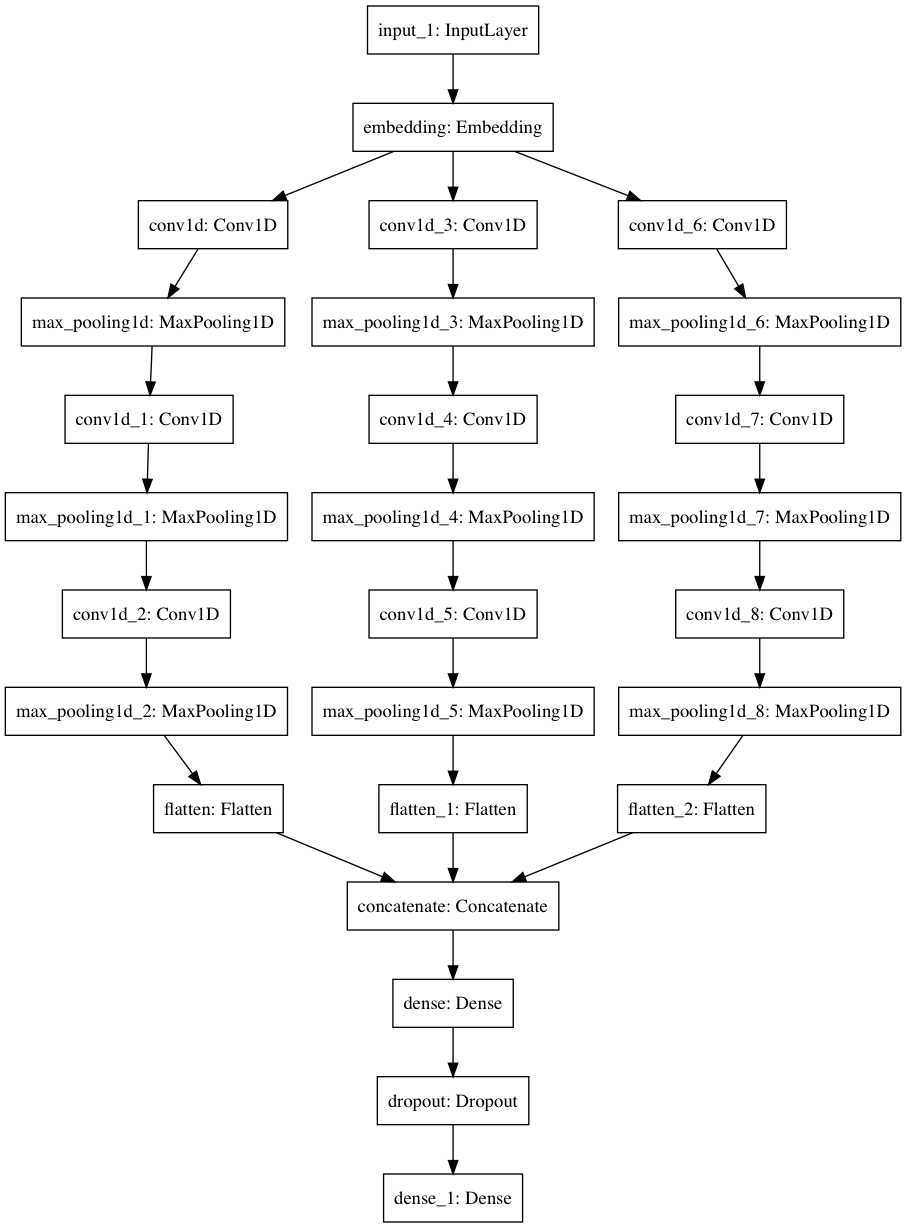

In [21]:
tf.keras.utils.plot_model(model)

In [22]:
# 训练模型
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          validation_data=(x_test, y_test))

Epoch 1/5
149/149 [==============================] - 113s 756ms/step - loss: 0.4749 - acc: 0.7530 - val_loss: 0.2158 - val_acc: 0.9194
Epoch 2/5
149/149 [==============================] - 118s 790ms/step - loss: 0.1433 - acc: 0.9509 - val_loss: 0.1758 - val_acc: 0.9365
Epoch 3/5
149/149 [==============================] - 123s 825ms/step - loss: 0.0432 - acc: 0.9889 - val_loss: 0.2023 - val_acc: 0.9351
Epoch 4/5
149/149 [==============================] - 130s 872ms/step - loss: 0.0184 - acc: 0.9962 - val_loss: 0.2522 - val_acc: 0.9275
Epoch 5/5
149/149 [==============================] - 120s 804ms/step - loss: 0.0114 - acc: 0.9983 - val_loss: 0.2897 - val_acc: 0.9280


In [23]:
# 预测
def predict(text):
    # 对句子分词
    cw = list(jieba.cut(text)) 
    word_id = []
    # 把词转换为编号
    for word in cw:
        try:
            temp = dict_text[word]
            word_id.append(temp)
        except:
            word_id.append(0)
    word_id = np.array(word_id)
    word_id = word_id[np.newaxis,:]
    sequences = pad_sequences(word_id, maxlen=1000, padding='post')  
    result = np.argmax(model.predict(sequences))
    if(result==1):
        print("positive comment")
    else:
        print("negative comment")
    

In [24]:
predict("东西质量不错，下次还会再来买")

positive comment


In [26]:
predict("东西质量不错个屁，下次不会再来买")

negative comment


# LSTM情感分类

In [28]:
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, concatenate
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential

In [2]:
# 读入数据
neg=pd.read_excel('data/neg.xls',header=None)
pos=pd.read_excel('data/pos.xls',header=None)

#合并语料
pn = pd.concat([pos,neg],ignore_index=True) 
#计算语料数目
neglen = len(neg)
print(neglen)
poslen = len(pos) 
print(poslen)

pn.head(1)

#定义分词函数
cw = lambda x: list(jieba.cut(x))
pn['words'] = pn[0].apply(cw)
pn.head(1)

# 一行数据最多的词汇数
max_document_length = max([len(x) for x in pn['words']])
max_document_length

# 设置一个评论最多1000个词
max_document_length = 1000

texts = [' '.join(x) for x in pn['words']]

# 实例化分词器，设置字典中最大词汇数为30000
tokenizer = Tokenizer(num_words=30000)
# 传入我们的训练数据，建立词典
tokenizer.fit_on_texts(texts) 
# 把词转换为编号，词的编号根据词频设定，频率越大，编号越小
sequences = tokenizer.texts_to_sequences(texts) 

# 把序列设定为1000的长度，超过1000的部分舍弃，不到1000则补0
sequences = pad_sequences(sequences, maxlen=1000, padding='post')  
sequences = np.array(sequences)

sequences.shape

# 词对应编号的字典
dict_text = tokenizer.word_index
dict_text['也']

# 定义标签
positive_labels = [1 for _ in range(poslen)]
negative_labels = [0 for _ in range(neglen)]
y = np.concatenate([positive_labels, negative_labels], 0)

# 打乱数据
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = sequences[shuffle_indices]
y_shuffled = y[shuffle_indices]

# 数据集切分为两部分
test_sample_index = -1 * int(0.1 * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

In [33]:
# 定义函数式模型
# 模型输入
sequence_input = Input(shape=(1000,))
# Embedding层，30000表示30000个词，每个词对应的向量为128维，序列长度为1000
embedding_layer = Embedding(30000,
                            128,
                            input_length=1000)
embedded_sequences = embedding_layer(sequence_input)

lstm = LSTM(64, return_sequences=True)(embedded_sequences)

x = Flatten()(lstm)
# 输出层
preds = Dense(2, activation='softmax')(x)
# 定义模型
model = Model(sequence_input, preds)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 128)         3840000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 64)          49408     
_________________________________________________________________
flatten_4 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 128002    
Total params: 4,017,410
Trainable params: 4,017,410
Non-trainable params: 0
_________________________________________________________________


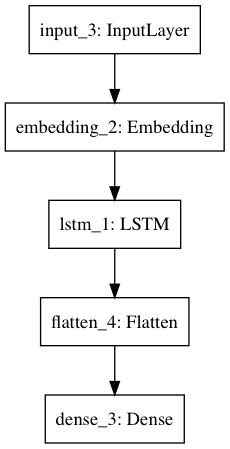

In [34]:
tf.keras.utils.plot_model(model)

In [35]:
# 训练模型
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          validation_data=(x_test, y_test))

Epoch 1/5
149/149 [==============================] - 186s 1s/step - loss: 0.3881 - acc: 0.8128 - val_loss: 0.1985 - val_acc: 0.9284
Epoch 2/5
149/149 [==============================] - 177s 1s/step - loss: 0.1262 - acc: 0.9564 - val_loss: 0.1874 - val_acc: 0.9351
Epoch 3/5
149/149 [==============================] - 182s 1s/step - loss: 0.0630 - acc: 0.9802 - val_loss: 0.1921 - val_acc: 0.9327
Epoch 4/5
149/149 [==============================] - 179s 1s/step - loss: 0.0374 - acc: 0.9906 - val_loss: 0.2881 - val_acc: 0.9327
Epoch 5/5
149/149 [==============================] - 180s 1s/step - loss: 0.0284 - acc: 0.9934 - val_loss: 0.2776 - val_acc: 0.9294


# 采用bilstm
效果应该是最好的，不过最后发生过拟合了！
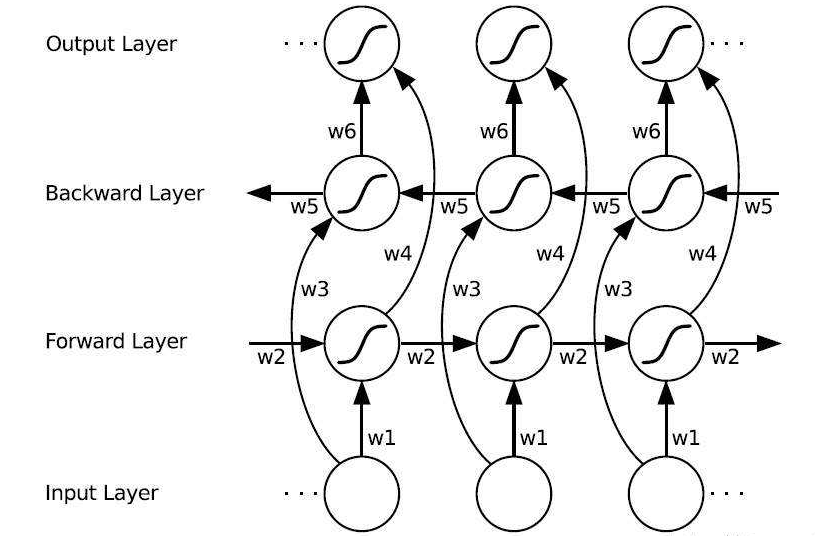

In [36]:
from tensorflow.keras.layers import Bidirectional
# 定义函数式模型
# 模型输入
sequence_input = Input(shape=(1000,))
# Embedding层，30000表示30000个词，每个词对应的向量为128维，序列长度为1000
embedding_layer = Embedding(30000,
                            128,
                            input_length=1000)
embedded_sequences = embedding_layer(sequence_input)

lstm = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)

x = Flatten()(lstm)
# 输出层
preds = Dense(2, activation='softmax')(x)
# 定义模型
model = Model(sequence_input, preds)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 128)         3840000   
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 128)         98816     
_________________________________________________________________
flatten_5 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 256002    
Total params: 4,194,818
Trainable params: 4,194,818
Non-trainable params: 0
_________________________________________________________________


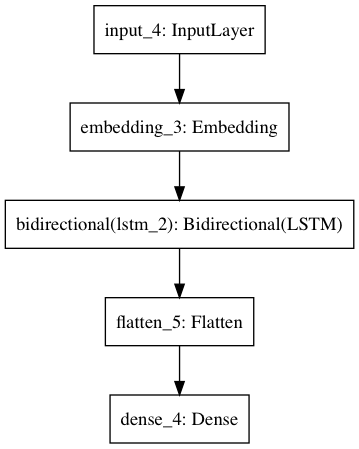

In [37]:
tf.keras.utils.plot_model(model)

In [38]:
# 训练模型
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          validation_data=(x_test, y_test))

Epoch 1/5
149/149 [==============================] - 295s 2s/step - loss: 0.4109 - acc: 0.8056 - val_loss: 0.2117 - val_acc: 0.9237
Epoch 2/5
149/149 [==============================] - 287s 2s/step - loss: 0.1220 - acc: 0.9576 - val_loss: 0.1754 - val_acc: 0.9360
Epoch 3/5
149/149 [==============================] - 297s 2s/step - loss: 0.0550 - acc: 0.9839 - val_loss: 0.2032 - val_acc: 0.9365
Epoch 4/5
149/149 [==============================] - 310s 2s/step - loss: 0.0398 - acc: 0.9905 - val_loss: 0.2435 - val_acc: 0.9332
Epoch 5/5
149/149 [==============================] - 322s 2s/step - loss: 0.0228 - acc: 0.9939 - val_loss: 0.2986 - val_acc: 0.9270


# cnn | lstm | bilstm 对比
cnn一个epoch的时间要快一些

在处理seq，lstm还是比cnn要更自然一些吧